In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import scipy.io
import matplotlib.pyplot as plt
import cmath
from numpy.random import permutation
from sklearn.decomposition import PCA
# import scipy.signal as signal
# from scipy.signal import welch
# from scipy.stats import skew
# from scipy.stats import kurtosis

2024-02-10 10:29:40.880693: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 10:29:41.458613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 10:29:41.458881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 10:29:41.533863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 10:29:41.724018: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 10:29:41.726240: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Encoder

In [50]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [74]:
latent_dim = 11

encoder_inputs = keras.Input(shape=(2600, 2, 1))
x = layers.Conv2D(64, (3, 2), activation="relu")(encoder_inputs)
x = layers.Conv2D(32, (3, 1), activation="relu")(x)
x = layers.Conv2D(16, (3, 1), activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 2600, 2, 1)]         0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 2598, 1, 64)          448       ['input_12[0][0]']            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 2596, 1, 32)          6176      ['conv2d_18[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 2594, 1, 16)          1552      ['conv2d_19[0][0]']           
                                                                                            

# Decoder

In [75]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(41504, activation="relu")(latent_inputs)
x = layers.Reshape((2594, 1, 16))(x)
x = layers.Conv2DTranspose(16, (3, 1), activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 1), activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 2), activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 1, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

           
                                                                                                  


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 11)]              0         
                                                                 
 dense_10 (Dense)            (None, 41504)             498048    
                                                                 
 reshape_3 (Reshape)         (None, 2594, 1, 16)       0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 2596, 1, 16)       784       
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 2598, 1, 32)       1568      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_11 (Conv2  (None, 2600, 2, 64)       1235

In [76]:
class VAE(keras.Model):
    @keras.saving.register_keras_serializable()
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# VAE

In [7]:
mat = scipy.io.loadmat('GSMData.mat')
data = mat['arraydata_GSM']

In [45]:
def create_data(data, init=0, end=1000):
    X = []
    Y = []
    for dev in range(11):               #number of devices 12 
        for burst in  range(init, end):         # number of bursts 1000 for each device
            signal_data = data[burst, : , dev]
            #signal_data = down_sample(signal_data)
            x = np.array([[v.real for v in signal_data], [v.imag for v in signal_data]]) # values of the complex numbers in the array of data
            X.append(x.T)

            y = [dev]
            Y.append(y)
    
    return np.array(X), np.array(Y)

np.random.seed(10)
p = permutation(1000*11)

X, y = create_data(data, end=len(data))
X, y = X[p], y[p]


x_train, y_train = X[:800*11, :, :], y[:800*11]
x_test, y_test = X[800*11:, :, :], y[800*11:]

print(x_train.shape, x_test.shape)

signals_x = np.expand_dims(x_train, -1)
print(signals_x.shape)


(8800, 2600, 2) (2200, 2600, 2)
(8800, 2600, 2, 1)


In [77]:
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# mnist_digits = np.concatenate([x_train, x_test], axis=0)
# print(mnist_digits.shape)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
# print(mnist_digits.shape)



vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(signals_x, epochs=10, batch_size=128)


Epoch 1/10
69/69 [==============================] - 159s 2s/step - loss: 785.2571 - reconstruction_loss: 355.1092 - kl_loss: 17.2155
Epoch 2/10
69/69 [==============================] - 163s 2s/step - loss: 22.8581 - reconstruction_loss: 20.1311 - kl_loss: 1.7538
Epoch 3/10
69/69 [==============================] - 166s 2s/step - loss: 18.6986 - reconstruction_loss: 17.4041 - kl_loss: 0.6191
Epoch 4/10
69/69 [==============================] - 167s 2s/step - loss: 16.4637 - reconstruction_loss: 15.6083 - kl_loss: 0.2199
Epoch 5/10
69/69 [==============================] - 171s 2s/step - loss: 13.2211 - reconstruction_loss: 12.6330 - kl_loss: 0.0852
Epoch 6/10
69/69 [==============================] - 172s 2s/step - loss: 11.9850 - reconstruction_loss: 11.8377 - kl_loss: 0.0356
Epoch 7/10
69/69 [==============================] - 164s 2s/step - loss: 11.6373 - reconstruction_loss: 11.6053 - kl_loss: 0.0173
Epoch 8/10
69/69 [==============================] - 170s 2s/step - loss: 11.4844 - reco

In [55]:
vae.save('vautoencoder_30epoch.keras')

/home/kaminari/miniconda3/envs/satnet/lib/python3.11/site-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [56]:
keras.models.load_model('vautoencoder_30epoch.keras')


TypeError: Could not locate class 'VAE'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'VAE', 'config': {}, 'registered_name': 'VAE', 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.0010000000474974513, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': None, 'metrics': None, 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}

In [79]:
x_train_v = np.expand_dims(x_train, -1)

encoded_signals, _,_ = vae.encoder.predict(x_train_v)
decoded_signals = vae.decoder(encoded_signals).numpy()
encoded_signals = np.array(encoded_signals)

print(x_train_v.shape)

print(encoded_signals.shape)

275/275 [==============================] - 10s 35ms/step
(8800, 2600, 2, 1)
(8800, 11)


In [80]:
print(x_train_v.shape)
print(decoded_signals.shape)
decoded_signals[:,:,0].shape

(8800, 2600, 2, 1)
(8800, 2600, 2, 1)


(8800, 2600, 1)

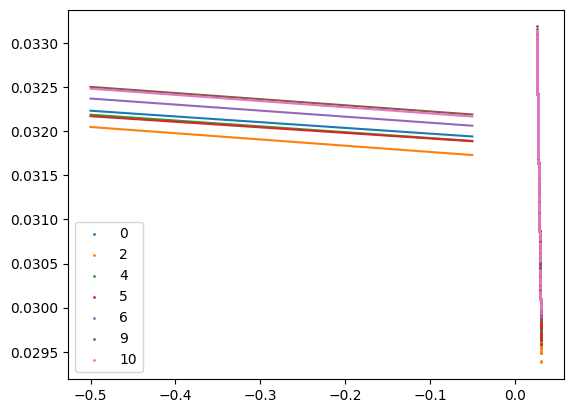

In [81]:
from sklearn.linear_model import Ridge


for i in np.unique(y_train.flatten()[0:11]):
    type_index = y_train.flatten()==i
    dec_x = encoded_signals[type_index][:, 0]
    dec_y =  encoded_signals[type_index][:, 1]
    clf = Ridge(alpha=1.0)
    clf.fit(dec_x.reshape(-1,1), dec_y.reshape(-1,1))
    
    new_dec_x =  np.arange(-0.5, 0, 0.05)
    plt.plot(new_dec_x, clf.predict(new_dec_x.reshape(-1,1)))
    plt.scatter(dec_x, dec_y, label=i, s=1 )
    plt.legend()

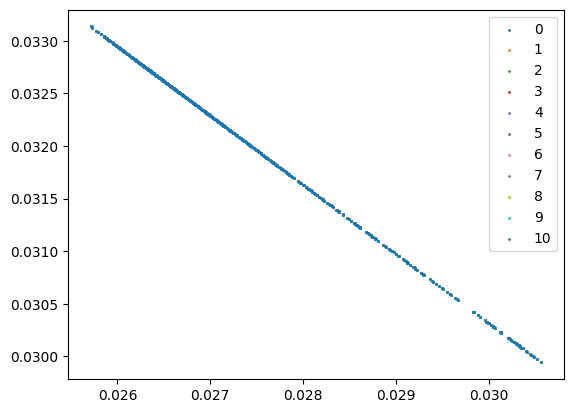

In [82]:
for i in np.unique(y_train.flatten()):
    type_index = y_train.flatten()==i

    plt.scatter(dec_x, dec_y, label=i, s=1)
    # print(type_index )
plt.legend()

int64
3


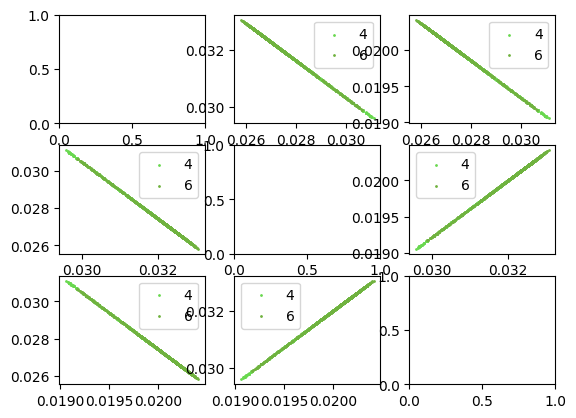

In [90]:
import matplotlib.colors as mcolors

cols = np.array(list(mcolors.XKCD_COLORS))

print(y.flatten().dtype)
latent_dim =3

fig, axs = plt.subplots(latent_dim, latent_dim)

for i in range(latent_dim):
    for j in range(latent_dim):
        if i==j:
            continue
        for l in np.unique(y_train.flatten()[0:2]):
            type_index = y_train.flatten()==l
            axs[i,j].scatter(encoded_signals[type_index][:, i], encoded_signals[type_index][:, j], c=cols[l], label=l, s=1)
        # if i==0 and j ==1:
            axs[i,j].legend()
print(latent_dim)
# for i in np.unique(y_test.flatten()):
#     type_index = y_test.flatten()==i

#     plt.scatter(encoded_signals[type_index][:, 0], encoded_signals[type_index][:, 1], label=i)
#     # print(type_index )
# plt.colorbar()
# plt.legend()

float32


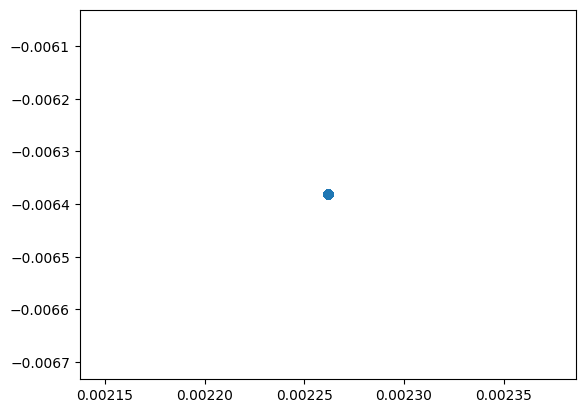

In [63]:
plt.scatter(encoded_signals[:,0], encoded_signals[:,1])
print(encoded_signals.dtype)

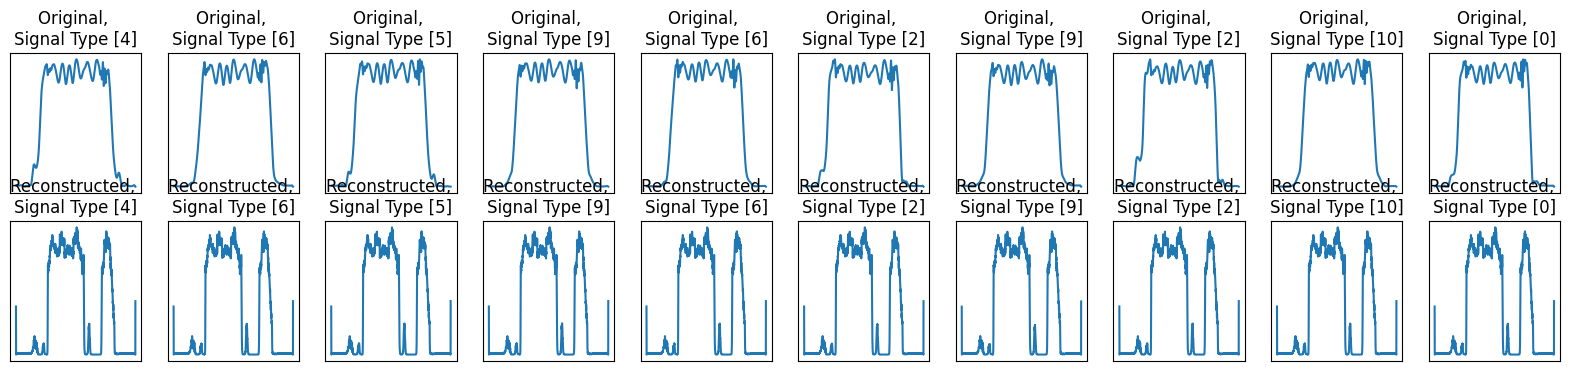

In [91]:
from numpy import linalg as LA
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  # plt.plot(x_test[i])
  plt.plot(LA.norm(signals_x[i, :, :], axis=1))
  plt.title("Original, \nSignal Type {}".format(y[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  # plt.imshow(decoded_imgs[i])
  plt.plot(LA.norm(decoded_signals[i, :, :], axis=1))
  plt.title("Reconstructed, \nSignal Type {}".format(y[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

[1.0000000e+00 8.2970394e-11]
[4.0262619e-01 3.6674448e-06]
(8800, 2)
8.620359e-05 3.9100033e-08
0.0006490889 3.912104e-08
0.0012877403 3.9063647e-08
0.00018268543 3.9079097e-08
0.00037320354 3.9107835e-08
0.00037992364 3.9082625e-08
-0.00057933625 3.9078778e-08
8.2174876e-05 3.9059344e-08
-9.777124e-06 3.906571e-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-0.0012861824 3.908983e-08
-0.0011542392 3.912204e-08


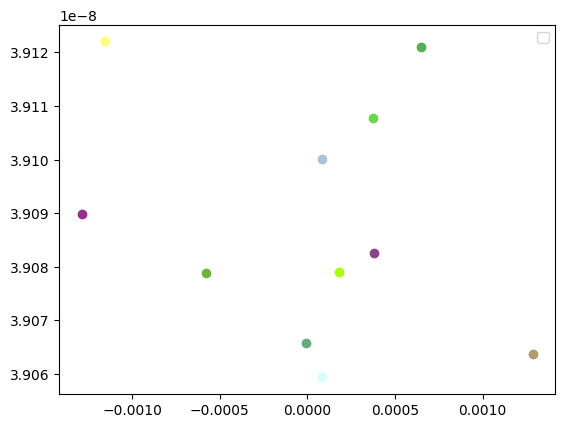

In [117]:
pca = PCA(n_components=2)

pca.fit(encoded_signals)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

pca_encoded = pca.transform(encoded_signals)
print(pca_encoded.shape)

cols = np.array(list(mcolors.XKCD_COLORS))

for i in np.unique(y_train.flatten()):
    type_index = y_train.flatten()==i

    pca_encoded_x = pca_encoded[type_index][:, 0]
    pca_encoded_y = pca_encoded[type_index][:, 1]
    # plt.scatter(pca_encoded_x,pca_encoded_y, label=i,s=1, c=cols[i])
    print(pca_encoded_x.mean(), pca_encoded_y.mean())
    plt.scatter(pca_encoded_x.mean(), pca_encoded_y.mean(), c=cols[i])
    # print(type_index )
plt.legend()